## 0. Setup

In [1]:
import os
from typing import Dict, Any
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import create_react_agent

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_API_KEY")
)

## 1. Sub Agents

In [4]:
research_worker = create_react_agent(
    name="research_worker",
    prompt=SystemMessage(
        content=(
            "You are a research specialist. Given a topic, find key information. "
            "Return ONLY JSON with: keywords, sources."
        )
    ),
    model=llm,
    tools=[],
)

In [5]:
type(research_worker)

langgraph.graph.state.CompiledStateGraph

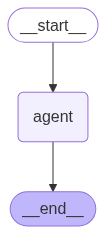

In [6]:
research_worker

In [7]:
writing_worker = create_react_agent(
    name="writing_worker",
    prompt=SystemMessage(
        content=(
            "You are a content writer. " 
            "Given research keywords, write clear and concise content. "
            "Return ONLY JSON with: content, summary."
        )
    ),
    model=llm,
    tools=[],
)

## 2. Handoff Tools

In [8]:
@tool
def call_researcher(topic: str) -> Dict[str, Any]:
    """Ask the research worker to find information about a topic."""
    message = HumanMessage(content=f"Research this topic: {topic}")
    
    result = research_worker.invoke(
        input={"messages": [message]}
    )
    
    last_message: AIMessage = result["messages"][-1]
    
    # Simple parsing (could use structured output for production)
    return {
        "task": "research",
        "topic": topic,
        "results": last_message.content
    }

In [9]:
@tool
def call_writer(research_keywords: str) -> Dict[str, Any]:
    """Ask the writing worker to create content based on research."""
    message = HumanMessage(
        content=f"Write a concise content based on these keywords: {research_keywords}"
    )
    
    result = writing_worker.invoke(
        input={"messages": [message]}
    )
    
    last_message:AIMessage = result["messages"][-1]
    
    return {
        "task": "writing",
        "research": research_keywords,
        "results": last_message.content
    }

## 3. Orchestrator

In [10]:
supervisor_agent = create_react_agent(
    name="supervisor_agent",
    prompt=SystemMessage(
        content=(
            "You are a task supervisor. When given a request:\n"
            "1. First use research_topic to gather information\n"
            "2. Then use write_content to create content based on the research\n"
            "3. Combine everything into a final response\n\n"
            "Use the tools in this order: research_topic → write_content"
        )
    ),
    model=llm,
    tools=[call_researcher, call_writer],
)

## 4. Run

In [11]:
result = supervisor_agent.invoke(
    input={
        "messages": [
            HumanMessage(
                content="topic machine learning basics"
            )
        ]
    }
)

In [12]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

topic machine learning basics
================================== Ai Message ==================================
Name: supervisor_agent
Tool Calls:
  call_researcher (call_HgQkNHn88Bi09IMIlL2WIacE)
 Call ID: call_HgQkNHn88Bi09IMIlL2WIacE
  Args:
    topic: machine learning basics
================================= Tool Message =================================
Name: call_researcher

{"task": "research", "topic": "machine learning basics", "results": "{\n  \"keywords\": [\n    \"machine learning\",\n    \"supervised learning\",\n    \"unsupervised learning\",\n    \"reinforcement learning\",\n    \"algorithms\",\n    \"data preprocessing\",\n    \"model training\",\n    \"overfitting\",\n    \"underfitting\",\n    \"neural networks\",\n    \"decision trees\",\n    \"support vector machines\",\n    \"feature selection\",\n    \"cross-validation\",\n    \"evaluation metrics\"\n  ],\n  \"sources\": [\n    \"http